# Лабораторна робота: Моделювання функції двох змінних нейронних мереж

Функція: $f(x, y) = x^2 + y^2$
діапазон: \(x, y \in [0, 10]\)

Реалізовано та досліджено типи мереж та архітектури, зазначені у завданні:
1. Feed-forward (1 hidden layer: 10 та 20 нейронів)
2. Cascade-forward (1x20 та 2x10)
3. Elman (SimpleRNN) (1x15 та 3x5)


### Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Add
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd

print('TensorFlow version:', tf.__version__)


2025-10-02 03:10:35.485736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759374635.880809      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759374636.006753      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


### Generate Data

In [2]:
def generate_data(n_samples=1000, low=0.0, high=10.0, seed=42):
    rng = np.random.RandomState(seed)
    X = rng.uniform(low, high, (n_samples, 2))
    Y = X[:, 0]**2 + X[:, 1]**2
    return X, Y

X, Y = generate_data(n_samples=1000)
X_train, X_test = X[:800], X[800:]
Y_train, Y_test = Y[:800], Y[800:]

print('Train shape:', X_train.shape, Y_train.shape)


Train shape: (800, 2) (800,)


In [3]:
def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=16, verbose=0):
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_test, Y_test))
    Y_pred = model.predict(X_test)
    denom = np.where(np.abs(Y_test) < 1e-8, 1e-8, np.abs(Y_test))
    error = np.mean(np.abs((Y_test - Y_pred.flatten()) / denom))
    r2 = r2_score(Y_test, Y_pred.flatten())
    return history, error, Y_pred.flatten(), r2


### Build Models

In [4]:
def build_models():
    models = {}
    models['FeedForward_10'] = Sequential([Input(shape=(2,)), Dense(10, activation='relu'), Dense(1)])
    models['FeedForward_20'] = Sequential([Input(shape=(2,)), Dense(20, activation='relu'), Dense(1)])

    inp = Input(shape=(2,))
    h = Dense(20, activation='relu')(inp)
    out = Dense(1)(h)
    skip = Dense(1)(inp)
    final = Add()([out, skip])
    models['Cascade_20'] = Model(inputs=inp, outputs=final)

    inp2 = Input(shape=(2,))
    h1 = Dense(10, activation='relu')(inp2)
    h2 = Dense(10, activation='relu')(h1)
    out2 = Dense(1)(h2)
    skip2 = Dense(1)(inp2)
    final2 = Add()([out2, skip2])
    models['Cascade_2x10'] = Model(inputs=inp2, outputs=final2)

    models['Elman_15'] = Sequential([Input(shape=(2,1)), SimpleRNN(15, activation='relu'), Dense(1)])
    models['Elman_3x5'] = Sequential([
        Input(shape=(2,1)),
        SimpleRNN(5, activation='relu', return_sequences=True),
        SimpleRNN(5, activation='relu', return_sequences=True),
        SimpleRNN(5, activation='relu'),
        Dense(1)
    ])
    return models

models = build_models()
print('Models built: ', list(models.keys()))


2025-10-02 03:10:57.671117: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Models built:  ['FeedForward_10', 'FeedForward_20', 'Cascade_20', 'Cascade_2x10', 'Elman_15', 'Elman_3x5']


### Train Models

In [5]:
results = {}
epochs = 200
batch_size = 16

X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

for name, model in models.items():
    print(f'Training {name} ...')
    if name.startswith('Elman'):
        history, error, Y_pred, r2 = train_and_evaluate(model, X_train_rnn, Y_train, X_test_rnn, Y_test, epochs=epochs, batch_size=batch_size, verbose=1)
    else:
        history, error, Y_pred, r2 = train_and_evaluate(model, X_train, Y_train, X_test, Y_test, epochs=epochs, batch_size=batch_size, verbose=1)
    results[name] = {'history': history.history, 'error': float(error), 'r2': float(r2), 'y_pred': Y_pred.tolist()}
    model.save(f'model_{name}.h5')

print('\nTraining finished.')


Training FeedForward_10 ...
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5851.6548 - val_loss: 5770.8218
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5683.3555 - val_loss: 5474.1465
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5470.5366 - val_loss: 5179.1406
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5386.1665 - val_loss: 4871.3027
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5206.5732 - val_loss: 4547.7271
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4573.1270 - val_loss: 4207.0386
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4107.9932 - val_loss: 3838.0979
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3815.1853 - val_loss: 3451.7446
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3171.2109 - val_loss: 3048.5115
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2762.6519 - val_loss: 2632.6228
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2

### Plot Results

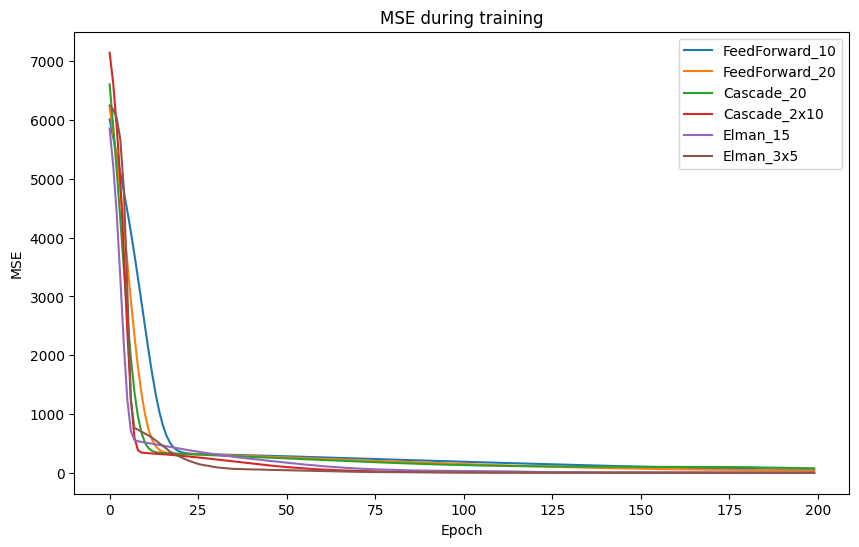

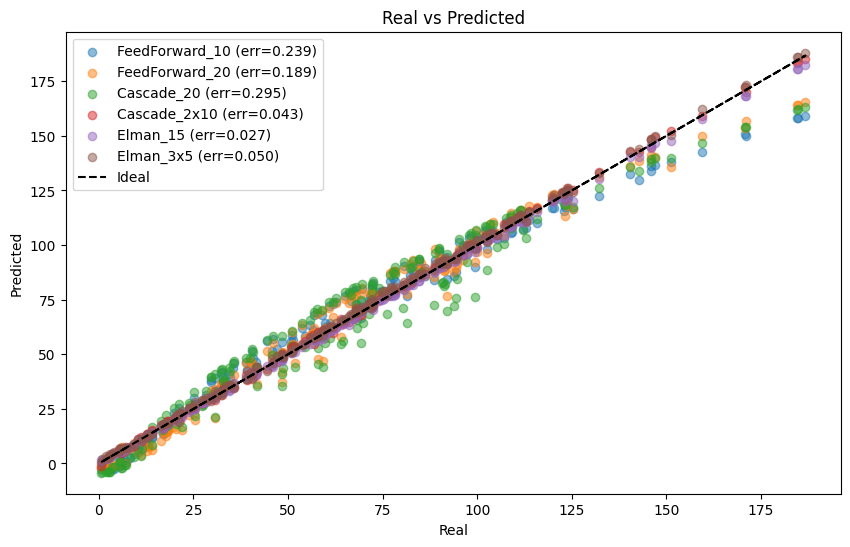

,model,mean_relative_error,r2
4,Elman_15,0.027457,0.999274
3,Cascade_2x10,0.042828,0.999265
5,Elman_3x5,0.049720,0.998488
1,FeedForward_20,0.188985,0.978688
0,FeedForward_10,0.239383,0.971642
2,Cascade_20,0.295434,0.958671


In [6]:
def plot_results(results):
    plt.figure(figsize=(10,6))
    for name, res in results.items():
        if 'loss' in res['history']:
            plt.plot(res['history']['loss'], label=name)
    plt.title('MSE during training')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    for name, res in results.items():
        y_pred = np.array(res['y_pred'])
        plt.scatter(Y_test, y_pred, label=f"{name} (err={res['error']:.3f})", alpha=0.5)
    plt.plot(Y_test, Y_test, 'k--', label='Ideal')
    plt.xlabel('Real')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title('Real vs Predicted')
    plt.show()

def summarize_results(results):
    rows = []
    for name, res in results.items():
        rows.append({'model': name, 'mean_relative_error': res['error'], 'r2': res['r2']})
    df = pd.DataFrame(rows).sort_values('mean_relative_error')
    return df

plot_results(results)
summarize_results(results)

### Plot surfaces for comparison

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


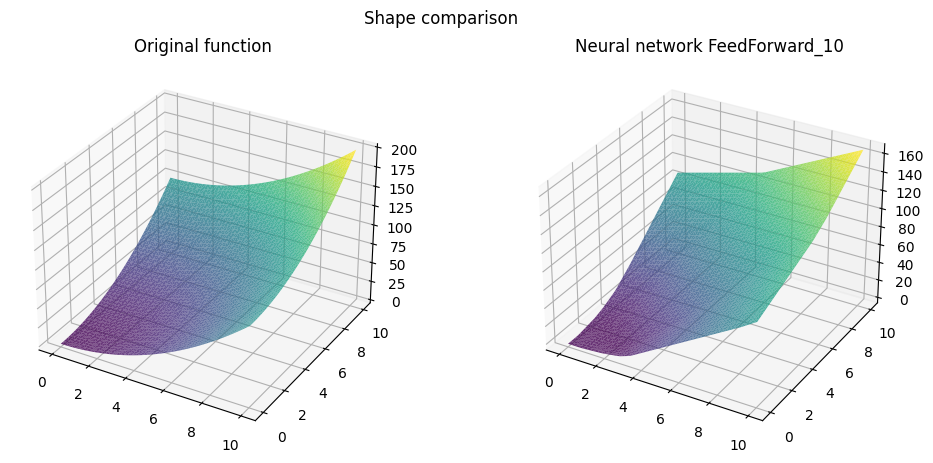

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


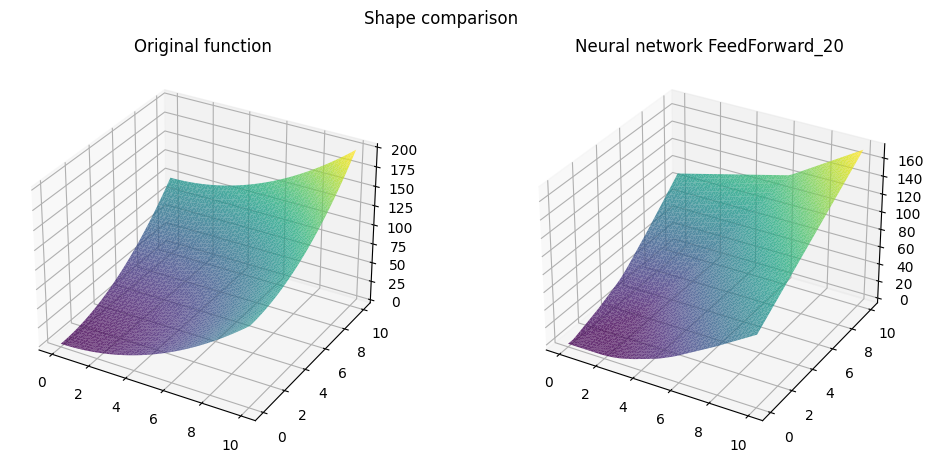

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


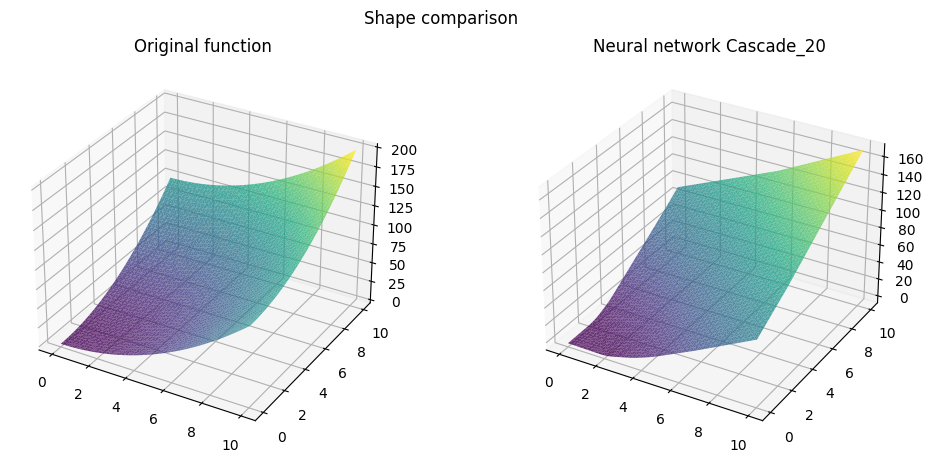

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


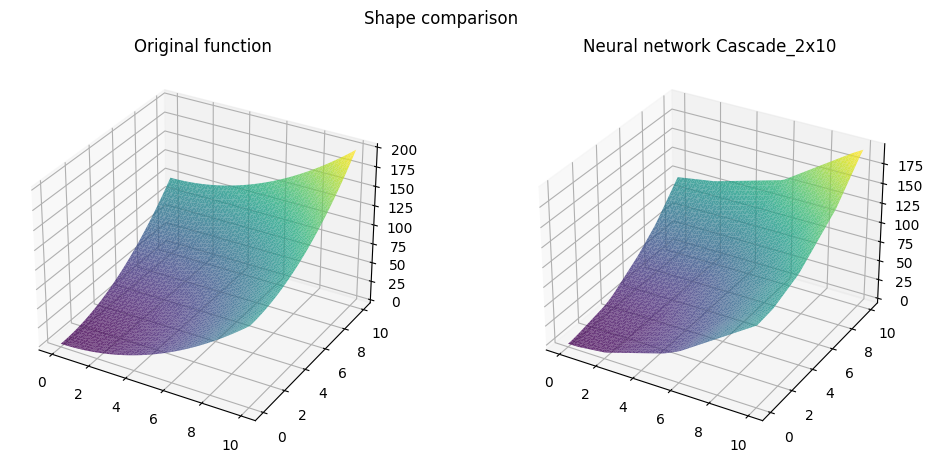

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


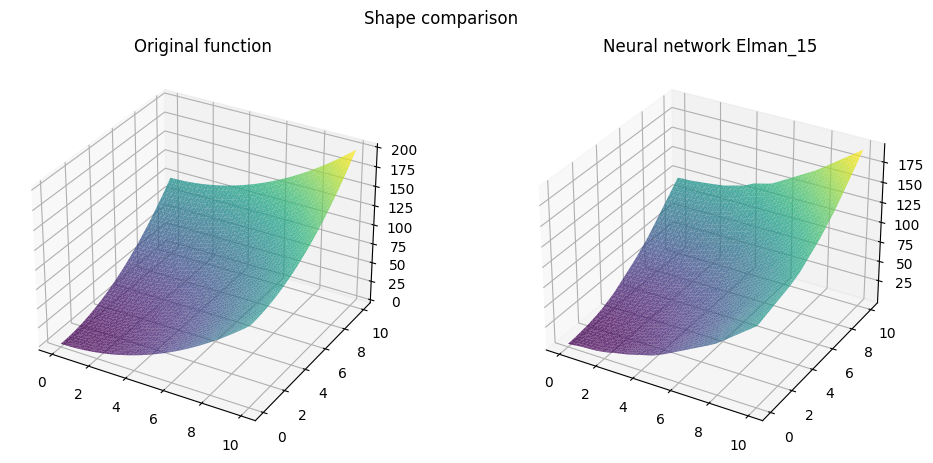

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


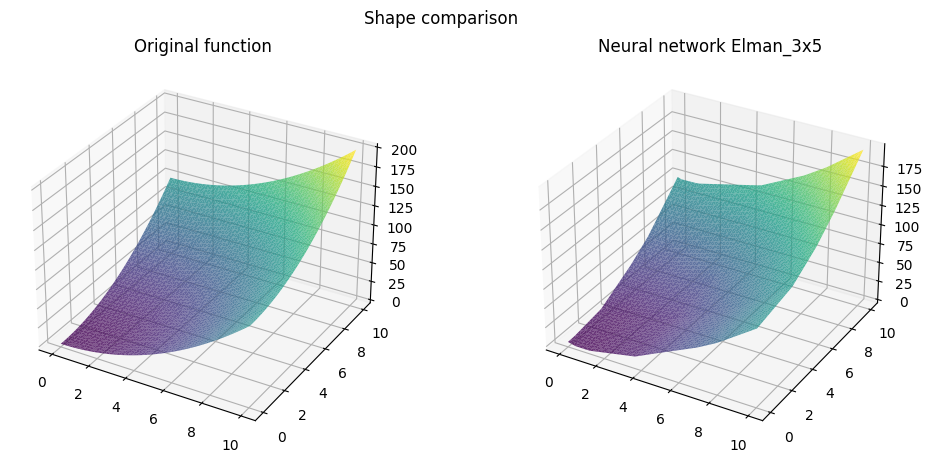

In [7]:
from mpl_toolkits.mplot3d import Axes3D

def plot_surface(name ,model, func, title='Shape comparison', rnn=False):
    x_lin = np.linspace(0, 10, 50)
    y_lin = np.linspace(0, 10, 50)
    Xg, Yg = np.meshgrid(x_lin, y_lin)
    XY = np.stack([Xg.flatten(), Yg.flatten()], axis=1)
    Z_true = func(XY[:,0], XY[:,1])

    if rnn:
        XY_in = XY.reshape((XY.shape[0], XY.shape[1], 1))
    else:
        XY_in = XY

    Z_pred = model.predict(XY_in).flatten()

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.plot_trisurf(XY[:,0], XY[:,1], Z_true, cmap='viridis', alpha=0.8)
    ax1.set_title('Original function')

    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.plot_trisurf(XY[:,0], XY[:,1], Z_pred, cmap='viridis', alpha=0.8)
    ax2.set_title('Neural network '+name)

    plt.suptitle(title)
    plt.show()

plot_surface('FeedForward_10',models['FeedForward_10'], lambda x,y: x**2+y**2, rnn=False)
plot_surface('FeedForward_20',models['FeedForward_20'], lambda x,y: x**2+y**2, rnn=False)
plot_surface('Cascade_20',models['Cascade_20'], lambda x,y: x**2+y**2, rnn=False)
plot_surface('Cascade_2x10',models['Cascade_2x10'], lambda x,y: x**2+y**2, rnn=False)
plot_surface('Elman_15',models['Elman_15'], lambda x,y: x**2+y**2, rnn=True)
plot_surface('Elman_3x5',models['Elman_3x5'], lambda x,y: x**2+y**2, rnn=True)